In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("anchit48/fine-tuned-sentiment-analysis-customer-feedback")
model = AutoModelForSequenceClassification.from_pretrained("anchit48/fine-tuned-sentiment-analysis-customer-feedback")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import torch

text = "Mirissa Beach is truly a gem on Sri Lanka’s southern coast! The soft, golden sand and crystal-clear waters are perfect for lounging or taking a dip"

def make_prediction(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

In [ ]:
negetive = "this very bad place I dont want to be here"
make_prediction(negetive)

0

In [ ]:
df_eval = pd.read_csv("/content/place_reviews_evaluation.csv")
df_eval.head()

,Review_Text,Sentiment
0,"The view from the top was breathtaking, the hi...",positive
1,The service was terrible and the place was dirty.,negative
2,Amazing experience! The guide was friendly and...,positive
3,"The food was cold and overpriced, very disappo...",negative
4,The beach was clean and the sunset was stunnin...,positive


In [ ]:
def convert_sentiment(data):
        if data == 'positive':
            return 1
        elif data == 'negative':
            return 0


In [ ]:
df_eval['Sentiment_encoded'] = df_eval['Sentiment'].apply(convert_sentiment)

In [ ]:
df_eval['Sentiment Predicted'] = df_eval['Review_Text'].apply(make_prediction)

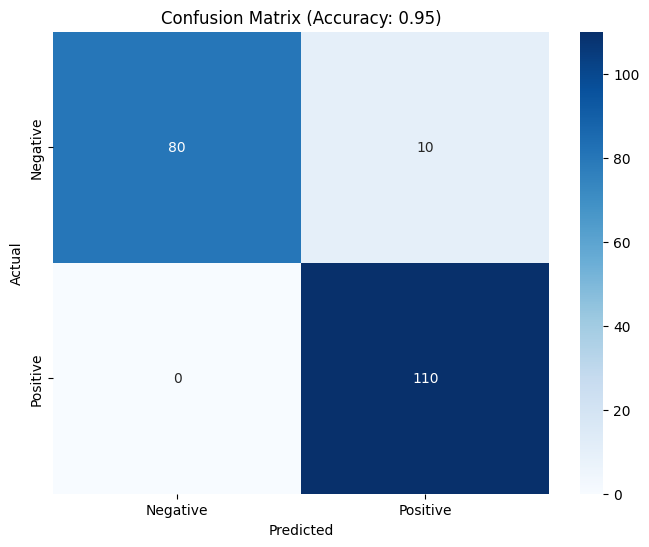

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df_eval['Sentiment_encoded'] , df_eval['Sentiment Predicted'])


accuracy = accuracy_score(df_eval['Sentiment_encoded'] , df_eval['Sentiment Predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.show()

In [ ]:
df_eval.head()

,Review_Text,Sentiment,Sentiment_encoded,Sentiment Predicted
0,"The view from the top was breathtaking, the hi...",positive,1,1
1,The service was terrible and the place was dirty.,negative,0,0
2,Amazing experience! The guide was friendly and...,positive,1,1
3,"The food was cold and overpriced, very disappo...",negative,0,0
4,The beach was clean and the sunset was stunnin...,positive,1,1


In [ ]:
df = pd.read_csv("/content/Places Dataset Enriched Filled.csv")

In [ ]:
import re

classified_reviews_array = []

def remove_non_ascii(s):
    return s.encode('ascii', 'ignore').decode('ascii')

def extract_list_items(string):
    review_sub_array = []
    string = remove_non_ascii(string)
    reviews = re.findall(r"'(.*?)'", string)

    for review in reviews:
        classification = make_prediction(review)
        review_sub_array.append(classification)
        classified_reviews_array.append(classification)

    print(review_sub_array)
    return review_sub_array

In [ ]:
x = extract_list_items(df["latest_reviews"][4])

[1, 1, 1, 1, 1, 1]


In [ ]:
df["latest_reviews"][4]

"['Hikkaduwa Beach is a delightful escape for solo travelers looking to unwind. The atmosphere is vibrant, with plenty of opportunities for surfing and snorkeling. I rented a surfboard from a local shop and had a fantastic time riding the waves. The beach itself is beautiful, but I did notice some areas could use a bit of maintenance. Overall, itÃ¢Â€Â™s a great spot for adventure and relaxation. Don't forget to check out the local food stalls for some delicious snacks!','As a family, we had an amazing time at Hikkaduwa Beach. The kids loved snorkeling and were thrilled to see colorful fish and even a turtle! The beach is spacious enough for everyone to find their perfect spot to relax. While the local shops were convenient, some prices felt a bit high. Still, the overall experience was wonderful, and we made unforgettable memories together.','Hikkaduwa Beach is a charming spot for a day out with friends. We enjoyed surfing in the morning and lounging on the sand afterward. The atmosphe

In [ ]:
df["classified_reviews"] = df["latest_reviews"].apply(extract_list_items)

[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 0, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 0, 0, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 0, 1, 1, 1]
[0, 

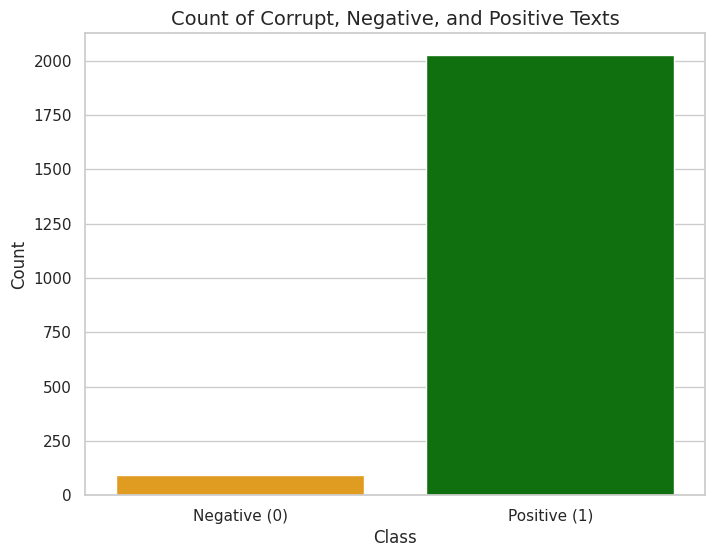

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

data = classified_reviews_array
counts = Counter(data)

df_2 = pd.DataFrame({
    'Class': ['Negative (0)', 'Positive (1)'],
    'Count': [counts[0], counts[1]]
})

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=df_2, hue='Class', palette=['orange', 'green'], dodge=False, legend=False)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of Corrupt, Negative, and Positive Texts', fontsize=14)

plt.show()


In [ ]:
def negetive_rate(array):
  negative_count = array.count(0)
  if len(array) > 0:
    return round(negative_count / len(array),2)
  else:
    return -1

In [ ]:
df["negetive_rate"]=df["classified_reviews"].apply(negetive_rate)

In [ ]:
df.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews,location_info,activities,Geographical,Historical,Religious,Natural,Entertainment,Accommodation,Shopping,Food,classified_reviews,negetive_rate
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.800000,1591.0,['Arugam Bay Beach is a surfer's paradise! I s...,"Arugam Bay Beach, located on Sri Lanka's south...","['Surfing', 'Wildlife Watching', 'Yoga Retreat...","Located on the eastern coast of Sri Lanka, Aru...",Arugam Bay has a history linked to the traditi...,"The area is home to several temples, with near...","Arugam Bay features beautiful sandy beaches, l...",Popular activities include beach parties and c...,Arugam Bay offers a range of accommodations fr...,"Local markets and small shops offer souvenirs,...",The area is known for fresh seafood and tradit...,"[1, 1, 1, 1, 1]",0.0
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.600000,1748.0,['Mirissa Beach is truly a gem on Sri LankaÃ¢Â...,"Mirissa Beach, located on Sri Lanka's southern...","['Whale watching', 'Snorkeling and diving', 'S...",Mirissa Beach is located on the southern coast...,Mirissa has a rich maritime history and has be...,The area is close to the significant Buddhist ...,The beach is known for its stunning natural be...,Mirissa is a popular spot for nightlife activi...,Various types of accommodations are available ...,"Local markets and shops offer handicrafts, bea...",Mirissa offers a variety of seafood options an...,"[1, 1, 1, 1, 1]",0.0
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.400000,325.0,['Weligama Beach is a fantastic spot for both ...,"Weligama Beach, located on Sri Lanka's souther...","['Surfing', 'Yoga classes', 'Whale watching', ...",Weligama Beach is located on the southern coas...,The area has a rich history as a fishing villa...,"Nearby temples, such as the Parrot Rock Temple...",Weligama Beach is known for its sublime sunset...,"The beach offers lively activities, including ...",Accommodation options range from guesthouses t...,Local markets and shops offer a variety of han...,"Seafood is abundant along the shore, with offe...","[1, 1, 1, 1, 1]",0.0
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",4.459437,582.5,['Ahangama was a bit disappointing for me as a...,"Ahangama, located on the southern coast of Sri...","['Surfing at Ahangama Beach', 'Exploring the K...",Ahangama is located on the southern coast of S...,Ahangama has a rich history connected to the c...,The town and surrounding areas have several Bu...,"Ahangama boasts beautiful beaches, coral reefs...",Ahangama is known for its vibrant surf culture...,"The area has a variety of guesthouses, villas,...","Local artisan shops sell handmade crafts, surf...",Ahangama features traditional Sri Lankan cuisi...,"[1, 1, 1, 0, 1]",0.2
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.700000,1438.0,['Hikkaduwa Beach is a delightful escape for s...,"Hikkaduwa Beach, located on the southwestern c...","['Snorkeling', 'Surfing', 'Glass Bottom Boat T...",Hikkaduwa is located on the southwestern coast...,Hikkaduwa has a rich history as a prominent po...,"The area is home to several Buddhist temples, ...",Hikkaduwa boasts a stunning marine environment...,Hikkaduwa is known for its lively beach scene ...,"Due to its popularity, Hikkaduwa offers a vari...",The area has a range of shops selling local cr...,Hikkaduwa has a vibrant food scene where you c...,"[1, 1, 1, 1, 1, 1]",0.0


In [ ]:
df.to_csv("Places Dataset Classified Reviews.csv", index=False)